In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

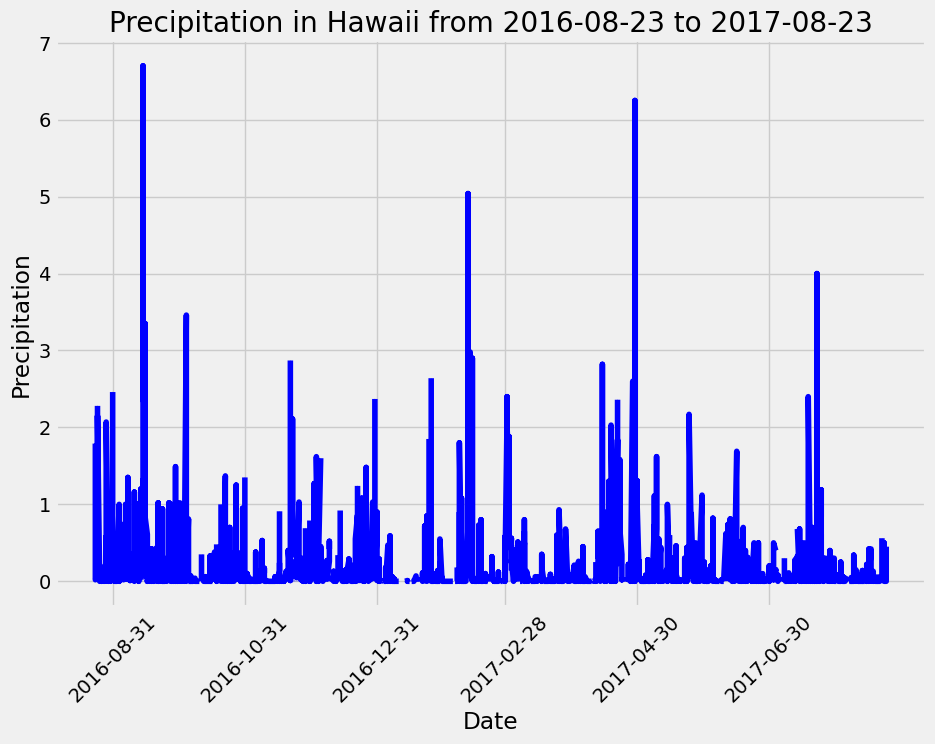

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()
one_year_ago = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data

# Set the index of the dataframe to the 'Date' column
precipitation_df.set_index('Date', inplace=True)

# Convert the index to a DatetimeIndex object
precipitation_df.index = pd.to_datetime(precipitation_df.index)

# Plot the data as a line graph with shading
plt.figure(figsize=(10,7))
plt.plot(precipitation_df.index, precipitation_df['Precipitation'], color='b', linestyle='-', label='Precipitation')
plt.fill_between(precipitation_df.index, precipitation_df['Precipitation'], color='b', alpha=0.2)

# Set the x and y labels and title
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title(f"Precipitation in Hawaii from {one_year_ago} to {latest_date}")

# Set the tick marks
major_ticks = pd.date_range(start=precipitation_df.index.min(), end=precipitation_df.index.max(), freq='2M')
plt.xticks(major_ticks, major_ticks.strftime('%Y-%m-%d'), rotation=45)

# Add a grid
plt.grid(which='major', axis='both', linestyle='-')

# Show the plot
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
mostactivestationdata

(54.0, 85.0, 71.66378066378067)

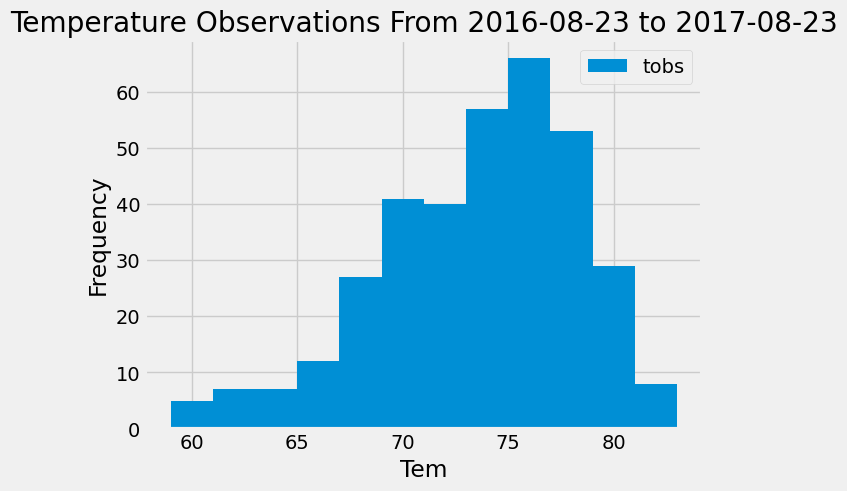

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Query to count the number of temperature observations for each station
station_counts = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

# Get the most active station id
most_active_station = station_counts[0][0]

# Query the last 12 months of temperature observation data for the most active station
last_year_temps = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a DataFrame
temp_df = pd.DataFrame(last_year_temps, columns=['Temperature'])

# Plot the histogram
plt.title(f"Temperature Observations From {one_year_ago} to {latest_date}")
plt.hist(temp_df['Temperature'], bins=12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel("Tem")
plt.legend()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()